In [5]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.patheffects as pe
import matplotlib_inline.backend_inline
import matplotlib.gridspec as gridspec
import matplotlib as mpl
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# On Off-Center Measurements of Circles

<div class="alert alert-warning">

<b>NB:</b> This post uses $\LaTeX$ for displaying math. If it hasn't rendered and loaded correctly, try refreshing the page or a different browser.
    
</div>

## Introduction

I was watching a video about a [radial planimeter from the 1920s](https://www.youtube.com/watch?v=jmtYW1lDP8M) (sounds esoteric, I know) used to measure the average radius of a circular shape, when I heard the following quote:

> It's a strange but true fact that the average radius as measured from the center of a circle is different from the average if you measure it off-center \[...\]

This quote was visually accompanied by something similar to the images at the top of this post, and I had to pause the video to digest the quote. 

Could shifting the point of measurement, even slightly, seriously lead to a different value for the average radius? Why wouldn't circular symmetry just recoup the loss in distance to the circumference with the corresponding gains? Is this average radius larger or smaller than the true radius?

Unable to mentally convince myself with some rough mental geometry, I set out to understand this quirk of circles a little better.

<div class="alert alert-info">

<b>Disclaimer</b>: I am <i>not</i> a mathematician. This post likely contains flawed/erroneous/non-rigorous mathematical statements and sentiments. Proceed with caution.
    
</div>

## The average off-center radius is always larger than the true radius

A unit circle has a radius $r$ of $1$ and is centered at $(0,0)$. The following are a few useful facts for a unit circle:

$$
\begin{align}
x^2+y^2=1 \\
x=\cos(\theta) \\
y=\sin(\theta)
\end{align}
$$

Given these, we can approximate the average radius from any off-center point $(x_0,y_0)\ne(0,0)$ by averaging the distances from $(x_0,y_0)$ to $n$ equidistant points on the unit circle's circumference. With $n$ points, we have an angle of $\theta=\frac{2\pi}{n}$ between the points from the center to make the points equidistant, and each point is given by $p_i=\left(\cos(\theta i),\sin(\theta i))\right)$ where $\forall i\in[0,n-1]$.

This is visualized for the point $(x_0,y_0)=(.25,.15)$ below:

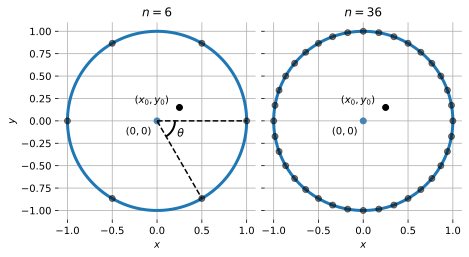

In [54]:
# <!-- collapse=True -->

fig  = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, width_ratios=[1,1])

(x0, y0) = (.25, .15)
ns = [6, 36]
theta = np.linspace(0,2*np.pi,1000)
xs, ys = np.cos(theta), np.sin(theta)

for n, s in zip(ns, [spec[0,0], spec[0,1]]):
    ax = fig.add_subplot(s)
    
    ax.plot(xs, ys, lw=3)
    ax.plot(0, 0, 'o', color='steelblue')
    ax.text(-.35,-.15,r"$(0,0)$")
    ax.set_xlabel(r"$x$")
    if n == min(ns): ax.set_ylabel(r"$y$")
    else: ax.set_yticklabels([])
    
    # points
    ax.plot(x0, y0, 'o', color='black')
    ax.text(-x0, y0+.05, r'$(x_0,y_0)$')
    t = 2*np.pi/n
    ax.plot([np.cos(t*i) for i in range(n)], [np.sin(t*i) for i in range(n)], 'o', color='black', alpha=.5)
    
    ax.set_aspect('equal')
    ax.set_title(rf'$n={n}$')
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.grid()

# Plot example theta
fig.axes[0].plot([0,np.cos(6*2*np.pi/6)], [0,np.sin(6*2*np.pi/6)], linestyle='dashed', color='black')
fig.axes[0].plot([0,np.cos(5*2*np.pi/6)], [0,np.sin(5*2*np.pi/6)], linestyle='dashed', color='black')
fig.axes[0].add_patch(mpl.patches.Arc((0,0), .4, .4, theta1=300, theta2=360, angle=2*np.pi/6, fill=False, lw=2))
fig.axes[0].text(.225,-.175,r"$\theta$",fontsize=11)

plt.show()

# <end collapse>

Then, we can use the Euclidean distance $d(\vec{p},\vec{q})=\sqrt{\sum_i{\left(q_i-p_i\right)^2}}$ for any two points $\vec{p}=(p_1,p_2)$ and $\vec{q}=(q_1,q_2)$ to calculate the distance from our off-center point $(x_0,y_0)$ to any equidistant point on the unit circle's circumference $p_i=\left(\cos(\theta i), \sin(\theta i) \right)$:

$$
\forall i : d_i = \sqrt{\left(\cos(\theta i) - x_0\right)^2 + \left(\sin(\theta i) - y_0 \right)^2}
$$

The average radius $\hat{r}$ measured from our off-center point is then just the arithmetic mean of the distances, or:

$$
\hat{r} = \frac{1}{n} \sum_{i=0}^{n-1}{\sqrt{\left(\cos(\theta i) - x_0\right)^2 + \left(\sin(\theta i) - y_0 \right)^2}}
$$

This is visualized again for $(.25, .15)$ below:

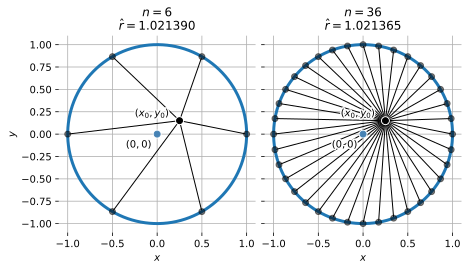

In [57]:
# <!-- collapse=True -->

def avg_r(x0, y0, n):
    t = 2*np.pi/n
    dists = [np.linalg.norm([np.cos(t*i)-x0, np.sin(t*i)-y0]) for i in range(n)]
    return np.mean(dists)

def plot_lines(x0, y0, n, ax=None):
    ax = plt.gca() if ax is None else ax
    
    # rays
    p0 = np.array([x0,y0])
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    dists = []
    
    for angle in angles:
        x = np.cos(angle)
        y = np.sin(angle)
        p = np.array([x,y])
        
        dists.extend([np.linalg.norm(p-p0)])
        ax.plot([x,x0], [y,y0], lw=1, color='black')

    return np.mean(dists)

# unit circle
(x0, y0) = (.25, .15)
ns = [6, 36]
theta = np.linspace(0,2*np.pi,1000)
xs, ys = np.cos(theta), np.sin(theta)

fig  = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# circle
for n, s in zip(ns, [spec[0,0], spec[0,1]]):
    ax = fig.add_subplot(s)
    r_hat = plot_lines(x0, y0, n, ax=ax)
    
    ax.plot(xs, ys, lw=3)
    ax.plot(0, 0, 'o', color='steelblue',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    ax.text(-.35,-.15,r"$(0,0)$",
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    ax.set_xlabel(r"$x$")
    if n == min(ns): ax.set_ylabel(r"$y$")
    else: ax.set_yticklabels([])
    
    # points
    ax.plot(x0, y0, 'o', color='black',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    ax.text(-x0, y0+.05, r'$(x_0,y_0)$',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    t = 2*np.pi/n
    ax.plot([np.cos(t*i) for i in range(n)], [np.sin(t*i) for i in range(n)], 'o', color='black', alpha=.5)
    
    ax.set_aspect('equal')
    ax.set_title(rf'$n={n}$' + '\n' + r"$\hat{r}=" + rf"{r_hat:.6f}$")
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.grid()

plt.show()

# <end collapse>

As we increase the number of lines or measurements to the circumference $n$, we also decrease the angle between these lines, $\theta$. But as the above diagrams show, different $n$ can yield different values of $\hat{r}$. In reality, these are just approximations of $\hat{r}$.

The "true" value of $\hat{r}$ is what we get if we kept decreasing $\theta$ (or equivalently, kept increasing $n$) such that $\theta\to0$. And as anyone who's taken a calculus course will tell you, adding up a bunch of terms that become smaller and smaller should get you thinking of integrals — which are [just fancy sums](https://xaktly.com/IntegralAsSum.html), in reality.

To take an integral with respect to $\theta$, we'll slightly rephrase the summation by dropping the $i$ term and dividing by the total number of angles ($2\pi$) rather than $1/n$ (you can think of this as averaging over all possible degrees of rotation of measuring from $(x_0,y_0)$ to the circumference):

$$
\hat{r} = \frac{1}{2\pi} \int_0^{2\pi}{\sqrt{\left(\cos(\theta) - x_0\right)^2 + \left(\sin(\theta) - y_0 \right)^2}}d\theta
$$

When measured from the center of the circle, $(x_0,y_0)=(0,0)$, we can show that the average radius is $1$ using the Pythagorean trigonometric identity $\sin^2\theta+\cos^2\theta=1$:

$$
\begin{align*}
\hat{r} &= \frac{1}{2\pi} \int_0^{2\pi}{\sqrt{\left(\cos(\theta) - x_0\right)^2 + \left(\sin(\theta) - y_0 \right)^2}}d\theta \\
&= \frac{1}{2\pi} \int_0^{2\pi}{\sqrt{\left(\cos(\theta) - 0\right)^2 + \left(\sin(\theta) - 0 \right)^2}}d\theta \\
&= \frac{1}{2\pi} \int_0^{2\pi}{1}d\theta \\ 
&= \frac{1}{2\pi} \theta\bigg|_0^{2\pi} \\
&= \frac{1}{2\pi} 2\pi \\
&= 1
\end{align*}
$$

Equivalently in Python, we have:

In [11]:
def r_int(x0=0, y0=0):
    f = lambda t : np.sqrt((np.cos(t)-x0)**2 + (np.sin(t)-y0)**2)
    return scipy.integrate.quad(f, 0, 2*np.pi)[0]/(2*np.pi)

and at $(x_0,y_0)=(0,0)$ our analytical solution yields:

In [12]:
r_int()

1.0

So what happens when $(x_0,y_0)\ne(0,0)$? Our numerical solution above (averaging distances from $(x_0,y_0)$ to equidistant points on the unit circle circumference) clearly suggests that $\hat{r}>1$ for $n=6,n=36$. In fact, we can show that for $n\ge3$, we will always achieve $\hat{r}>1$ when $(x_0,y_0)\ne(0,0)$.

Before we get to why $\hat{r}>1$, note that the first case of $n=1$ is an average over "one equidistant point," which is just the distance to that point. Secondly, the $n=2$ case yields $\hat{r}=1$ for all off-center points where $y_0=0$ (this can be algebraically proved). The $n=3$ case is therefore the first acceptable size of $n$ for "averaging" over the equidistant distances that satisfy the $\hat{r}>1$ condition.

With smaller $n$, the "average off-center radius" is _biased_ in certain locations due to fewer number of equidistant points sampled:

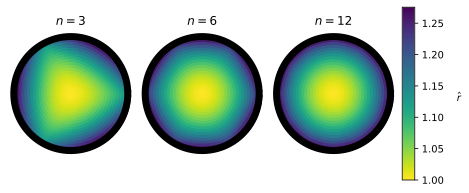

In [120]:
# <!-- collapse=True -->

def spiral_points(arc=1, separation=1, lim=1):
    # adapted from liborm; https://stackoverflow.com/questions/13894715/draw-equidistant-points-on-a-spiral
    def p2c(r, phi):
        return (r * math.cos(phi), r * math.sin(phi))

    res = [(0,0)]
    d = 0
    r = arc
    b = separation / (2 * np.pi)

    phi = float(r) / b
    while np.linalg.norm(np.array(res[-1])) < lim:
        res += [p2c(r, phi)]
        phi += float(arc) / r
        r = b * phi
    return res[:-1]

from matplotlib.cm import ScalarMappable

ps = np.array(spiral_points(.05,.05,1))
ns = [3, 6, 12]
fig  = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig, width_ratios=[1, 1, 1, 0.1])

# circle
for n, s in zip(ns, [spec[0,0], spec[0,1], spec[0,2]]):
    ax = fig.add_subplot(s)
    ax.axis('off')

    ax.scatter(ps[:,0],
               ps[:,1],
               c=[avg_r(*p,n) for p in ps],
               cmap='viridis_r')
    
    ax.set_aspect('equal')
    ax.set_title(rf'$n={n}$')
    # ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.grid()

    # unit circle
    theta = np.linspace(0,2*np.pi,1000)
    xs, ys = np.cos(theta), np.sin(theta)
    ax.plot(xs, ys, lw=7, color="black")

# Add colorbar
cbar_ax = fig.add_subplot(spec[0, 3])
cbar_ax.set_aspect(50)  # Modify this value to change the aspect ratio of the colorbar
norm = plt.Normalize(vmin=np.min([avg_r(*p, n) for p in ps]), vmax=np.max([avg_r(*p, n) for p in ps]))
mappable = ScalarMappable(cmap='viridis_r', norm=norm)
cbar = plt.colorbar(mappable, cax=cbar_ax)
cbar.set_label('$\hat{r}$', rotation=0, labelpad=15)

plt.show()

# <end collapse>

Observe how there are $n$ "spikes" that are poor approximations close to the circumference. You can see these clearly for $n=3$ and $n=6$, but by $n=12$ they are a little less obvious — if you squint, it looks like a uniform gradient.

By $n=50$, these points of poor accuracy essentially vanish:

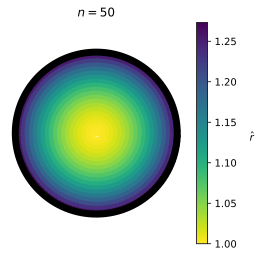

In [143]:
# <!-- collapse=True -->
plt.figure(figsize=(4,4))
plt.axis('off')
plt.scatter(ps[:,0],
           ps[:,1],
           c=[avg_r(*p,50) for p in ps],
           cmap='viridis_r')

plt.axis('equal')
plt.title(rf'$n=50$')
cbar = plt.colorbar()
cbar.set_label('$\hat{r}$', rotation=0, labelpad=15)

# unit circle
theta = np.linspace(0,2*np.pi,1000)
xs, ys = np.cos(theta), np.sin(theta)
plt.plot(xs, ys, lw=7, color="black")

plt.show()
# <end collapse>

For sufficient $n$ or the analytical solution, these circular plots are superfluous because of circular symmetry: we can simply plot how $\hat{r}$ changes as we get uniformly farther from the center:

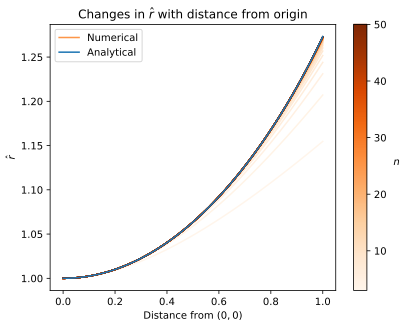

In [170]:
# <!-- collapse=True -->
rs    = np.linspace(0,1,1000)
avgs  = [r_int(r,0) for r in rs]

plt.title("Changes in $\hat{r}$ with distance from origin")
plt.xlabel("Distance from $(0,0)$")
plt.ylabel("$\hat{r}$")

sm = ScalarMappable(cmap='Oranges', norm=plt.Normalize(3, 50))
sm.set_array([])

for n in range(3, 51):
    plt.plot(
        rs,
        [avg_r(r, 0, n) for r in rs],
        color=sm.to_rgba(n),
        label="Numerical" if n == 50//2 else None,
    )
plt.plot(rs, avgs, label="Analytical")

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('$n$', rotation=0, labelpad=10)

plt.legend()
plt.show()
# <end collapse>

It's clear both our analytical and numerical solutions agree that $\hat{r}>1$. But why is this? Despite all this work, there is no clear intuition behind why the average radius becomes _greater_ than the true radius when measured off-center — it almost feels like it violates some kind of conservation property of distances.

An explanation is given in [this forum](https://math.stackexchange.com/questions/4764228/average-distance-from-point-to-unit-circle/4764245#4764245), and I'll repeat the visualization here (but be sure to read the original thread):



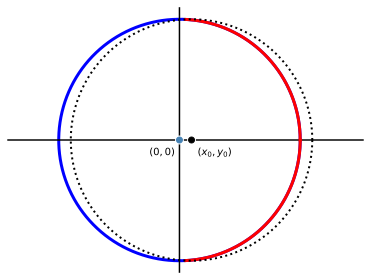

In [480]:
# <!-- collapse=True -->
def plot_shifted_circle_overlap(x0,y0):
    plt.axis('off')
    plt.axis('equal')
    
    # unit circle
    theta = np.linspace(0,2*np.pi,1000)
    xs, ys = np.cos(theta), np.sin(theta)
    plt.plot(xs, ys, lw=3, color="blue")

    # grid lines; origins
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    
    plt.plot(0, 0, 'o', color='steelblue',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    plt.text(-.25,-.125,r"$(0,0)$",
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    plt.plot(x0, y0, 'o', color='black',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    plt.text(x0+.05,y0-.125,r"$(x_0,y_0)$",
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    
    # shifted circle
    plt.plot(xs + x0, ys + y0, lw=2, color='black', linestyle='dotted', zorder=5)

    # draw in semicircles to prevent connecting across circle
    for (start,end) in [(np.pi, 2*np.pi), (0, np.pi)]:
        theta = np.linspace(start, end, 1000)
        xs, ys = np.cos(theta), np.sin(theta)
        points_within = np.array([[x,y] for (x,y) in zip(xs,ys) if np.linalg.norm([x0-x,y0-y]) <= 1])
        plt.plot(points_within[:, 0], points_within[:, 1], lw=3, c='red')
        
    plt.show()

plot_shifted_circle_overlap(.1, .0)
# <end collapse>

Let's begin with a slight shift away from $(0,0)$ of $(x_0,y_0)=(.1,0)$. We'll draw the unit circle in blue, and the circle originating at $(x_0,y_0)$ with a dotted line. Finally, let's color every point on the unit circle circumference that falls inside the shifted circle red.

By doing so, we have essentially visualized the distances of every point on the unit circle's circumference to $(x_0,y_0)$: red points have a distance of $1$ or less, and blue points have a distance strictly greater than $1$. In the above image, there are evidently more blue points than red points, but this does not imply the average radius would be greater than $1$.

However, in fact, for $(x_0,y_0)=(.1,0)$, the average distance from $(x_0,y_0)$ to all red points is $\approx0.9368$, and the average distance to all blue points is $\approx1.0641$. Yet, when all of the distances are averaged, we find that $\hat{r}\approx1.0025$ — so $\hat{r}$ is indeed greater than $1$.

It's easier to understand why $\hat{r}>1$ for all $(x_0,y_0)\ne(0,0)$ with a more extreme example:

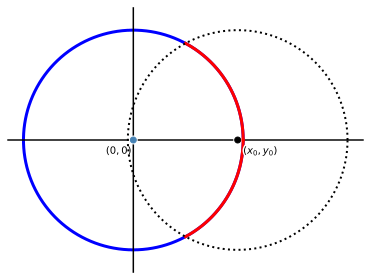

In [481]:
plot_shifted_circle_overlap(.95, 0)

When $(x_0,y_0)=(.95,0)$, the average distance from the off-center point to all red and blue points is $\approx0.5167$ and $\approx1.6222$ respectively, with $\hat{r}\approx1.2433$. In this example, it's clear that the reason $\hat{r}>1$ is not just because there are more blue points, but because there are _sufficiently more blue points that are farther away_.

## The average off-center diameter is always smaller than the true diameter

Part two of this post is an easier to come to — there is a nice and intuitive mental way to convince yourself that the above statement is true. I'll start with this informal proof, and then work toward a closed solution for the average diameter as measured from any off-center point within a circle.

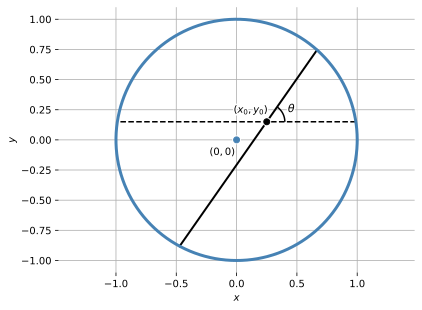

In [482]:
# <!-- collapse=True -->
def diameter_intercepts(x0,y0,t):
    """t is in radians."""
    c = (y0 - x0*np.tan(t))
    
    if t == np.pi/2 or np.isclose(t,np.pi/2):
        x1 = x2 = x0

        y1 = np.sqrt(1-x1**2)
        y2 = -np.sqrt(1-x2**2)
    else:
        x1 = (np.sqrt(-4*c**2 + 4*np.tan(t)**2 + 4) - 2*c*np.tan(t))/(2 * (np.tan(t)**2 + 1))
        x2 = (-np.sqrt(-4*c**2 + 4*np.tan(t)**2 + 4) - 2*c*np.tan(t))/(2 * (np.tan(t)**2 + 1))

        y1 = x1*np.tan(t) + c
        y2 = x2*np.tan(t) + c
    return (x1,y1), (x2,y2)

def plot_diameter(x0=0, y0=0, theta=0, show_diameter=False):
    """Theta is in degrees."""
    plt.grid()
    plt.axis('equal')
    plt.gca().spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")

    # draw line segment
    t = theta * (np.pi/180)
    (x1, y1), (x2, y2) = diameter_intercepts(x0, y0, t)
    plt.plot([x1,x2], [y1,y2], c='black', lw=2)

    # horizontal line
    (a0,b0), (a1,b1) = diameter_intercepts(x0,y0,0)
    plt.plot([a0,a1],[b0,b1], c='black', linestyle='dashed')

    # draw diameter
    if show_diameter:
        (x11,y11), (x12,y12) = diameter_intercepts(x0,y0,np.arctan(y0/x0))
        plt.plot([x11,x12],[y11,y12],c='steelblue',lw=2)

    # draw unit circle
    thetas = np.linspace(0,2*np.pi,1000)
    xs, ys = np.cos(thetas), np.sin(thetas)
    plt.plot(xs, ys, lw=3, color="steelblue")
    plt.plot(0, 0, 'o', color='steelblue',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    plt.text(-.225,-.125,r"$(0,0)$",
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    
    # draw off-center point
    plt.plot(x0, y0, 'o', color='black',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])
    plt.text(x0-.275, y0+.075, r'$(x_0,y_0)$',
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])

    # plot theta
    plt.gca().add_patch(mpl.patches.Arc((x0,y0),
                                        .3, .3, 
                                        theta1=0, theta2=theta, 
                                        fill=False, lw=1.5,
                                        zorder=5))
    plt.text(x0+.175,y0+.08,r"$\theta$",fontsize=11,
            path_effects=[pe.withStroke(linewidth=3, foreground='w')])

plot_diameter(.25, .15, theta=55)
plt.show()
# <end collapse>

Imagine one measurement such as the above, in which we draw a line at an angle $\theta$ from the  horizontal axis, and measure the distance between its intersection points on the unit circle circumference. This is one measurement that will make up our average diameter $\hat{d}$. Now, if we vary $\theta$, rotating this line, we will get a new line with a new distance.

What can we say about these distances? The definition of the diameter $d$ is that it is the straight line segment that passes through the center of the circle. This is the maximal width of a circle. Clearly, for rotations of $\theta$, our off-center lines do not pass through the center of the circle, so they are not maximal widths.

That is to say, rotations of these lines are, by some degree, all shorter than the diameter. There is only one rotation in which the length is equal to the diameter, which is when (by definition) the line passes through the center (pictured below):

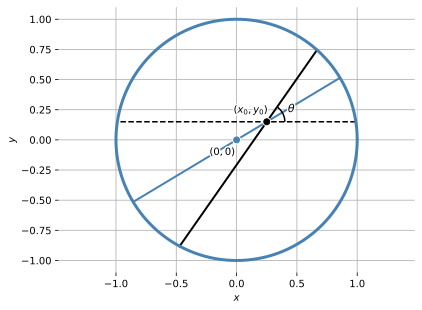

In [483]:
plot_diameter(.25, .15, theta=55, show_diameter=True)

Put simply, an average of lengths that are $<d$ with one length $=d$ will clearly lead to $\hat{d}<d$ (for the unit circle, $\hat{d}<2$).

So that's the informal proof, but can we quantitatively prove it? (We can, but it's kind of involved.)

---

Let's start by formulating an equation for each line. A straight line is given by $y=\alpha\cdot x + \beta$, where $\alpha$ is the gradient (slope), and $\beta$ is the $y$-intercept. Let's start with the gradient:

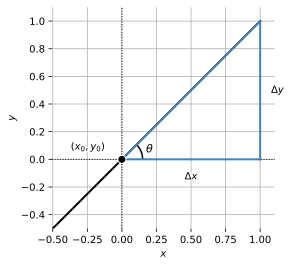

In [484]:
# <!-- collapse=True -->
plt.figure(figsize=(4,4))
plt.grid()
plt.axis('equal')
plt.gca().spines[['top', 'bottom', 'left', 'right']].set_visible(False)

plt.axhline(0, lw=1, linestyle='dotted', c='black')
plt.axvline(0, lw=1, linestyle='dotted', c='black')
plt.plot([-1,1],[-1,1], lw=2, c='black')

plt.plot([1,1], [0,1], lw=2, c='steelblue')
plt.plot([0,1], [0,1], lw=2, c='steelblue')
plt.plot([0,1], [0,0], lw=2, c='steelblue')

plt.plot(0, 0, 'o', color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='w')])
plt.text(-.37, .07, r'$(x_0,y_0)$',
        path_effects=[pe.withStroke(linewidth=3, foreground='w')])

# plot theta
plt.gca().add_patch(mpl.patches.Arc((0,0),
                                    .3, .3, 
                                    theta1=0, theta2=45, 
                                    fill=False, lw=1.5,))
plt.text(.175,.05,r"$\theta$",fontsize=11,
        path_effects=[pe.withStroke(linewidth=3, foreground='w')])

# text
plt.text(.5, -.125, r'$\Delta x$', va='center', ha='center',
        path_effects=[pe.withStroke(linewidth=3, foreground='w')])
plt.text(1.125, .5, r'$\Delta y$', va='center', ha='center',
        path_effects=[pe.withStroke(linewidth=3, foreground='w')])

plt.xlim(-.5,1.1)
plt.ylim(-.5,1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()
# <end collapse>

Recalling that $\tan\theta$ is the length of the opposite side of $\theta$ divided by the adjacent side, we have

$$
\tan\theta = \frac{\Delta y}{\Delta x} = \alpha
$$

Making our line $y=x\cdot\tan\theta + \beta$. To solve for $\beta$, we already know a point on the line ($(x_0,y_0)$), so we can just do some algebra:

$$
\begin{align*}
y&=x\cdot\tan\theta + \beta \\
y_0&=x_0\tan\theta+\beta \\
\therefore \beta&=y_0-x_0\tan\theta
\end{align*}
$$

making our final equation

$$
\begin{align}
y=x\cdot\tan\theta+\left(y_0-x_0\cdot\tan\theta\right)
\end{align}
$$

The length of this line enclosed by the unit circle is just the distance between the two points of intersection with the unit circle. Since we know the unit circle is given by $x^2+y^2=1$, we can solve for these points:

Firstly, let's redefine the unit circle equation in terms of $y$:

$$
\begin{align*}
x^2+y^2=1 \\
y = \sqrt{1-x^2}
\end{align*}
$$

Secondly, let's set this equal to our line to yield the $y$-intersections (maintaining $\beta$ for simplicity):

$$
\begin{align*}
\sqrt{1-x^2} &= x\cdot\tan\theta + \beta \\
1 - x^2 &= x^2\cdot\tan^2\theta + 2x\beta\cdot\tan\theta + \beta^2 \\
0 &= 1 - \beta^2 - 2x\beta\cdot\tan\theta + x^2\left(-\tan^2\theta-1\right) \\
&= x^2 - \frac{2\beta\cdot\tan\theta}{-\tan^2\theta-1}x + \frac{-\beta^2+1}{-\tan^2\theta-1}
\end{align*}
$$

which we can plug into the quadratic formula to yield:

$$
x = \frac{\pm\sqrt{-4\beta^2 + 4\tan^2(\theta)+4}-2\beta\tan(\theta)}{2\left(\tan^2(\theta)+1\right)}
$$

and thus

$$
y = \left(\frac{\pm\sqrt{-4\beta^2 + 4\tan^2(\theta)+4}-2\beta\tan(\theta)}{2\left(\tan^2(\theta)+1\right)}\right)\tan(\theta) + \beta
$$

So in total we have two points $(x_1,y_1)$ and $(x_2,y_2)$ given by our four values for $x$ and $y$. Now, we can just compute the distance $\hat{d}_{(x_0,y_0);\theta}$ between them. (Note: expanded forms are largely omitted since it gets very messy, very quickly.)

$$
\begin{align*}
\hat{d}_{(x_0,y_0);\theta} &= \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2} \\
&= \cdots \\
&= \sqrt{\left(-4 \cos^2(\theta)\left(\beta^2 \cos^2(\theta) - 1\right)\right) + \left(-4 \sin^2(\theta) \left(\beta^2 \cos^2(\theta) - 1\right)\right)} \\
&= \sqrt{4-4\beta^2\cos^2(\theta)} \\
&= \sqrt{4-4\left(y_0-x_0\tan\theta\right)^2\cos^2(\theta)}
\end{align*}
$$

Which is a pretty nice form for what we started with. Let's do some sanity checking by plugging in the origin — we know this should give us $d=2$ for any rotation:

$$
\begin{align*}
\hat{d}_{(0,0);\theta} &= \sqrt{4-4\left(0-0\tan\theta\right)^2\cos^2(\theta)} \\
&= \sqrt{4-4\cdot0^2\cdot\cos^2(\theta)} \\
&= \sqrt{4-0} = 2
\end{align*}
$$

Great. Now, converting our single-angle expression to an integral, we have:

$$
\hat{d}_{(x_0,y_0)} = \frac{1}{\pi} \int_0^\pi {\sqrt{4-4\left(y_0-x_0\tan\theta\right)^2\cos^2(\theta)}} d\theta
$$

Here, we only need to average over $\pi$, since we look at opposite points (and the circle is symmetrical). For the origin, we've shown the integrand is $2$, so we have

$$
\begin{align*}
\hat{d}_{(0,0)} &= \frac{1}{\pi} 2\theta\bigg|_0^\pi \\
&= \frac{1}{\pi} 2\pi = 2
\end{align*}
$$

And similar to the average radius, we can define this as a Python function:

In [485]:
def d_int(x0=0, y0=0):
    f = lambda t : np.sqrt(4 - 4*(y0 - x0*np.tan(t))**2*np.cos(t)**2)
    return scipy.integrate.quad(f, 0, np.pi)[0]/(np.pi)

d_int()

2.0

And we can visualize how the average diameter decreases as we stray from the origin:

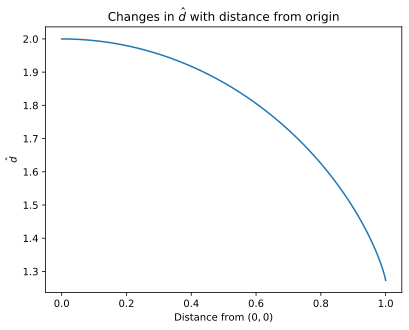

In [486]:
rs    = np.linspace(0,1,1000)
avgs  = [d_int(r,0) for r in rs]

plt.title("Changes in $\hat{d}$ with distance from origin")
plt.xlabel("Distance from $(0,0)$")
plt.ylabel("$\hat{d}$")

plt.plot(rs, avgs)
plt.show()

To show that $\hat{d}$ must always be less than $d=2$, we can revisit the Euclidean distance between the two points of intersection for some $\theta$:

$$
\hat{d}_{(x_0,y_0);\theta} = \sqrt{4-4\left(y_0-x_0\tan\theta\right)^2\cos^2(\theta)}
$$

We can observe that when $(x_0,y_0)\ne(0,0)$, the second term $4\left(y_0-x_0\tan\theta\right)^2\cos^2(\theta)>0$ except for when $\theta=\pi/2$ (note $\tan\left(\frac{\pi}{2}\right)$ is undefined) or when the $y$-intercept term $\beta=y_0-x_0\tan\theta=0$. Let this second term be denoted by $\phi$ for clarity, so we have $\hat{d}_{(x_0,y_0);\theta} = \sqrt{4-\phi}$ where $\phi>0$, implying $4-\phi < 4$ and therefore $\sqrt{4-\phi}=\hat{d}_{(x_0,y_0);\theta}<2$ for any $\theta\ne\pi/2$ and $(x_0,y_0)\ne(0,0)$.

If any line segment about the off-center point is less than $2$ apart from one line of length $2$, then the average (integral) of these segments will clearly be less than $2$. In other words,

$$
\forall (x_0,y_0) : (x_0,y_0)\ne(0,0) \implies \frac{1}{\pi} \int_0^\pi {\sqrt{4-4\left(y_0-x_0\tan\theta\right)^2\cos^2(\theta)}} d\theta = \hat{d}_{(x_0,y_0)} < 2
$$

## Conclusion

TODO.